# Анализ бизнес-показателей сайта Яндекс.Афиши

Отдел маркетинговой аналитики Яндекс.Афиши, просит помочь маркетологам снизить расходы на рекламу, перераспределить бюджет и отказаться от невыгодных источников трафика.


У нас есть данные посещений, заказов и рекламных расходов Яндекс.Афиши с июня 2017, по конец мая 2018 года. 


Нам предстоит изучить:
- как клиенты пользуются сервисом (количество пользователей, сессий, как часто возвращаются на сайт);
- через сколько времени совершаются первые покупки;
- сколько денег приносит компании каждый клиент (средний чек, общая выручка);
- когда расходы на привлечение клиента окупаются (затраты на маркетинг, стоимость привлечения одного покупателя) 

## Загрузка и подготовка данных к анализу

Импортируем необходимые для работы библиотеки.

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

Прочитаем данные из таблиц с **посещениями, заказами и затратами на маркетинг**.

In [139]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Рассмотрим общую информацию таблицы с **посещениями сайта**.

In [140]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [141]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Проверим на пропуски и дубликаты

In [142]:
visits.isna().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [143]:
visits.duplicated().sum()

0

Для удобства, приведём названия столбцов к нижнему регистру и часть переименуем.

In [144]:
visits.columns = visits.columns.str.lower()
visits.rename(columns={
    'end ts':'session_end_ts', 'source id':'source_id', 'start ts':'session_start_ts'
}, inplace=True)
visits.columns

Index(['device', 'session_end_ts', 'source_id', 'session_start_ts', 'uid'], dtype='object')

Узнаем уникальные устройства ('device'), с которых пользователи посещали сайт а, также, идентификаторы источников перехода.

In [145]:
visits.device.unique()

array(['touch', 'desktop'], dtype=object)

Мобильные и настольные устройства.

In [146]:
np.sort(visits.source_id.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10])

Источники трафика пронумерованы с первого по десятый. Данные по восьмому источнику отсутствуют.

Приведём столбцы с посещениями сайта к формату "дата-время".

In [147]:
visits.session_end_ts = pd.to_datetime(visits.session_end_ts)
visits.session_start_ts = pd.to_datetime(visits.session_start_ts)
visits.dtypes

device                      object
session_end_ts      datetime64[ns]
source_id                    int64
session_start_ts    datetime64[ns]
uid                         uint64
dtype: object

Перейдём к **таблице с информацией о заказах**. Рассмотрим общую информацию.

In [148]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [149]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Значения в столбце "доход" (Revenue), представлены в условных единицах.

Проверим на дубликаты и пропуски.

In [150]:
orders.duplicated().sum()

0

In [151]:
orders.isna().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

Приведём названия столбцов к нижнему регистру и переименуем необходимые.

In [152]:
orders.columns = orders.columns.str.lower()
orders.rename(columns={'buy ts':'order_ts'}, inplace=True)
orders.columns

Index(['order_ts', 'revenue', 'uid'], dtype='object')

Узнаем базовые статистики по выручке.

In [153]:
orders.revenue.describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

В среднем - 5 у.е. с одного заказа. Минимальное значение - 0. Возможно, сбой во время оформления покупки (следует указать на это поддержке). Максимальное значение - 2633 у.е. Кто-то раскошелился? Но, возможно, "слиплись" данные нескольких заказов или произошёл какой-то иной сбой.

Приведём столбец с датой заказа к формату "дата-время".

In [154]:
orders.order_ts = pd.to_datetime(orders.order_ts)
orders.dtypes

order_ts    datetime64[ns]
revenue            float64
uid                 uint64
dtype: object

Наконец, **таблица с информацией о расходах на маркетинг**.

In [155]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [156]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [157]:
costs.duplicated().sum()

0

In [158]:
costs.isna().sum()

source_id    0
dt           0
costs        0
dtype: int64

Переименуем столбец с датой.

In [159]:
costs.rename(columns={'dt':'date'}, inplace=True)
costs.date = pd.to_datetime(costs.date)
costs.dtypes

source_id             int64
date         datetime64[ns]
costs               float64
dtype: object

Посмотрим на уникальные источники трафика.

In [160]:
np.sort(costs.source_id.unique())

array([ 1,  2,  3,  4,  5,  9, 10])

В отличие от таблицы с посещениями, здесь отсутствует, также, шестой и седьмой источник.

## Рассчёт метрик и постройка графиков

Необходмио посчитать метрики трёх видов:
- **продуктовые**,
- **метрики электронной коммерции**,
- **маркетинговые**.

### 2.1. Продуктовые метрики

**2.1.1. Рассчёт DAU, WAU и MAU**.

Как много пользователей приходит в день? Узнаем число уникальных посетителей.

В таблице с посещениями, создадим столбцы с датой сессии, неделей, месяцем, годом.

In [161]:
visits['sess_date'] = visits.session_start_ts.dt.date
visits['sess_year'] = visits.session_start_ts.dt.year
visits['sess_month'] = visits.session_start_ts.dt.month
visits['sess_week'] = visits.session_start_ts.dt.week
visits.head()

,device,session_end_ts,source_id,session_start_ts,uid,sess_date,sess_year,sess_month,sess_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,12,51
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2,8
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,7,26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,5,20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,12,52


Посчитаем количество уникальных пользователей в день **(Daily Active Users)** и узнаем **среднее** за весь период.

In [162]:
dau_total = visits.groupby('sess_date').agg({'uid': 'nunique'}).mean()
int(dau_total)

907

В среднем - 907 человек в день. Построим график общей активности пользователей.

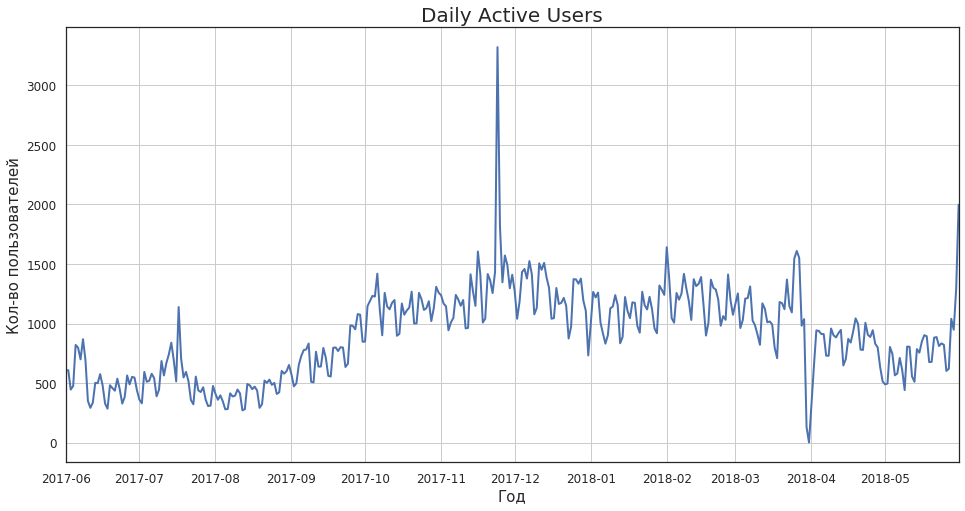

In [163]:
visits.groupby('sess_date').agg({'uid': 'nunique'}).\
plot(lw=2, grid=True, figsize=(16, 8), fontsize='large', legend=None)
plt.xlim('2017-06-01', '2018-05-31')
plt.title('Daily Active Users', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Кол-во пользователей', fontsize=15)
plt.show()

Виден рост до октября 2017 года, затем аномальный всплеск в конце ноября и такое же резкое падение посещений в конце марта 2018. В мае - очередное повышение активности.

Узнаем количество уникальных пользователей в неделю **(Weekly Active Users)** и узнаем среднее за весь период.

In [164]:
wau_total = visits.groupby(['sess_year', 'sess_week']).agg({'uid': 'nunique'}).mean()
int(wau_total)

5716

Построим график активности за весь период.

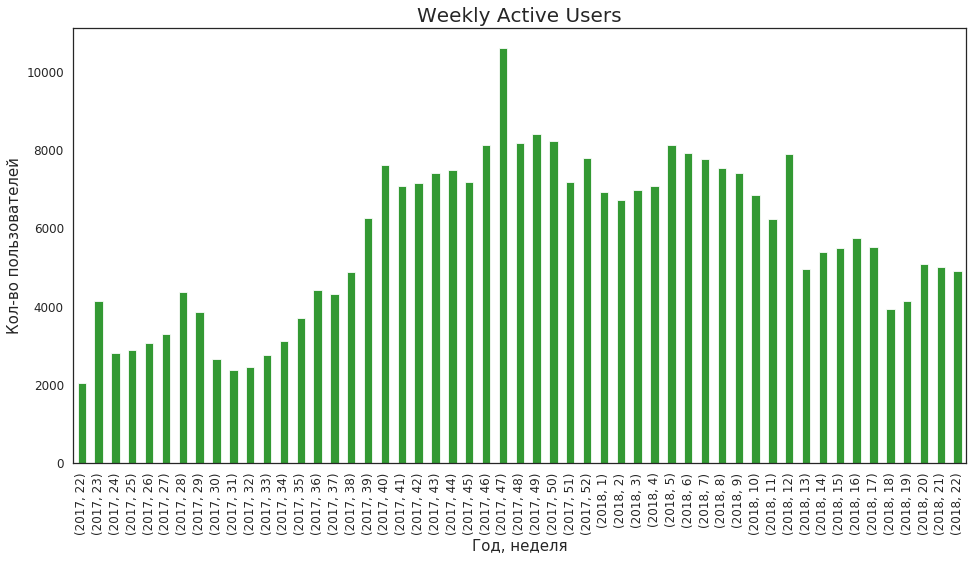

In [165]:
visits.groupby(['sess_year', 'sess_week']).agg({'uid': 'nunique'}).\
plot.bar(figsize=(16, 8), color='green', alpha=0.8, fontsize='large', legend=None)
plt.title('Weekly Active Users', fontsize=20)
plt.xlabel('Год, неделя', fontsize=15)
plt.ylabel('Кол-во пользователей', fontsize=15)
plt.show()

Та же картина, что и с "дневной" активностью. Разбивка по неделям, поэтому не так заметны выбросы.

Уникальные пользователи по месяцам **(Monthly Active Users)**.

In [166]:
mau_total = visits.groupby(['sess_year', 'sess_month']).agg({'uid': 'nunique'}).mean()
int(mau_total)

23228

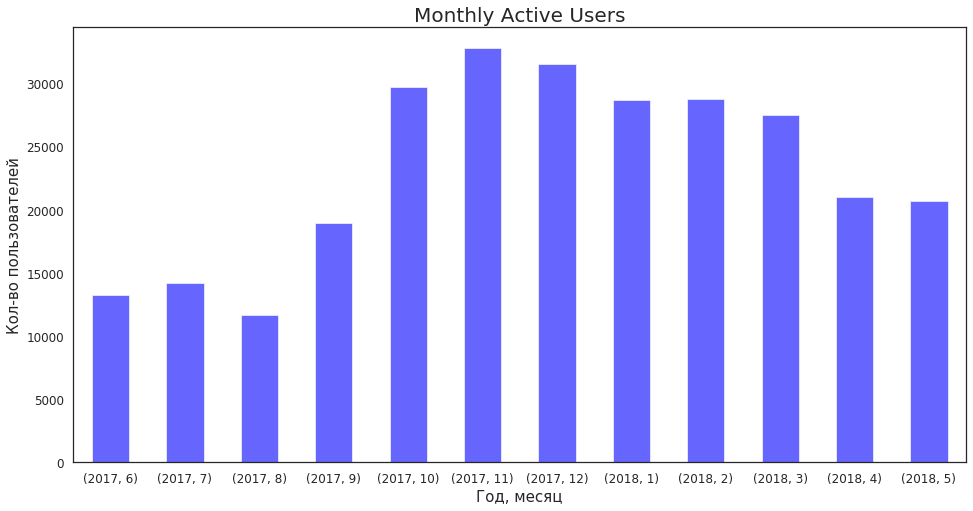

In [167]:
visits.groupby(['sess_year', 'sess_month']).agg({'uid': 'nunique'}).\
plot.bar(figsize=(16, 8), color='blue', alpha=0.6, fontsize='large', legend=None, rot=0)
plt.title('Monthly Active Users', fontsize=20)
plt.xlabel('Год, месяц', fontsize=15)
plt.ylabel('Кол-во пользователей', fontsize=15)
plt.show()

Рост с июня по ноябрь 2017, затем медленный, но верный, спад.

Узнаем недельный и месячный фактор вовлечённости пользователей - **Sticky factor**. Как часто обращаются к сайту.

In [168]:
print('Sticky WAU = {} %'.format(int((dau_total / wau_total) * 100)))
print('Sticky MAU = {} %'.format(int((dau_total / mau_total) * 100)))

Sticky WAU = 15 %
Sticky MAU = 3 %


Sticky WAU = 15% и Sticky MAU = 3% - практически минимальные значения, которые могут принимать данные метрики (14% и 3% соответственно). Следовательно, пользователи не задерживаются на сайте. Продолжим наши исследования.

**2.1.2. Определим, сколько раз за день пользователи в среднем заходят на сайт**.

In [169]:
session_per_user = visits.groupby('sess_date').agg({'uid': ['count', 'nunique']})
session_per_user.columns = ['n_sessions', 'n_users']
session_per_user['session_per_user'] = session_per_user['n_sessions'] / session_per_user['n_users']
round(session_per_user['session_per_user'].mean())

1

В среднем - один раз. Построим график.

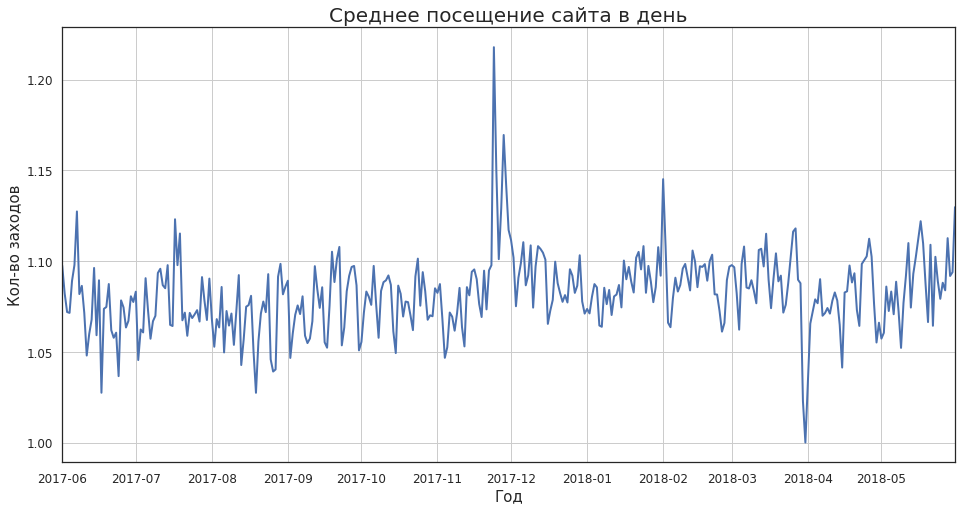

In [170]:
session_per_user.\
plot(y='session_per_user', lw=2, grid=True, figsize=(16, 8), fontsize='large', legend=None)
plt.xlim('2017-06-01', '2018-05-31')
plt.title('Среднее посещение сайта в день', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Кол-во заходов', fontsize=15)
plt.show()

Исключив "всплески", можно сделать вывод, что среднее количество посещений сайта пользователем в день, за весь период, остается постоянным, но не более одного раза.

**2.1.3. Узнаем продолжительность типичной пользовательской сессии за весь период**.

Метрика **ASL (Average Session Length)** показывает, сколько длится сессия пользователя в среднем.

In [171]:
visits['sess_duration_sec'] = (visits['session_end_ts'] - visits['session_start_ts']).dt.seconds
print(round(visits['sess_duration_sec'].mean()), 'секунды')

644 секунды


Около 10 минут. Но среднее значение подвержено влиянию выбросов. Построим гистограмму и посмотрим на распределение.

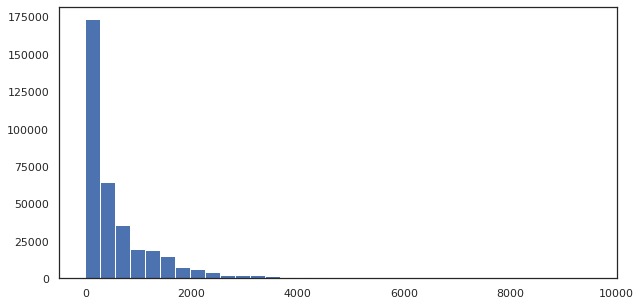

In [172]:
visits['sess_duration_sec'].hist(figsize=(10, 5), bins=300, grid=False)
plt.xlim(-500, 10000)
plt.show()

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду - значение во множестве наблюдений, которое встречается наиболее часто

In [173]:
visits['sess_duration_sec'].mode()

0    60
dtype: int64

Типичная пользовательская сессия равна шестидесяти секундам, или одной минуте. Человек зашёл на сайт, оформил покупку и тут же вышел. Пользователи не задерживаются. Видимо, реклама содержит исчерпывающую информацию о мероприятии - остаётся только купить билет!

**2.1.4. Рассчитаем коэффициент удержания - Retention Rate.**

Используем когортный анализ, где когортами будут месяцы, когда пользователи впервые пришли на сайт.

Вспомним таблицу с посещениями.

In [174]:
visits.head()

,device,session_end_ts,source_id,session_start_ts,uid,sess_date,sess_year,sess_month,sess_week,sess_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,12,51,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2,8,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,7,26,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,5,20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,12,52,0


 Возьмём дату, когда пользователь впервые проявил активность и добавим её в таблицу.

In [175]:
user_birth_date = visits.groupby(['uid'])['session_start_ts'].min()
user_birth_date.name = 'first_visit_date'

visits = visits.merge(user_birth_date, on='uid', how='left')

Создадим столбец с **первым месяцем посещения (когортой)** и столбец с месяцем посещения, для подсчёта времени жизни когорты.

In [176]:
visits['first_visit_month'] = visits.first_visit_date.astype('datetime64[M]')
visits['visit_month'] = visits.session_start_ts.astype('datetime64[M]')

Рассчитаем время жизни, **"lifetime"**, когорт.

In [177]:
visits['cohort_lifetime'] = (visits['visit_month'] - visits['first_visit_month'])
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Сгруппируем данные по когорте и "lifetime". Узнаем количество активных пользователей для каждой когорты.

In [178]:
cohorts = visits.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head()

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Выделим исходное количество пользователей в когорте на нулевой месяц.

In [179]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count

,first_visit_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Переименуем столбец с количеством пользователей.

In [180]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Объединим данные по когортам с исходным количеством пользователей в когорте и рассчитаем Retention Rate. Для этого разделим количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте:

In [181]:
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту

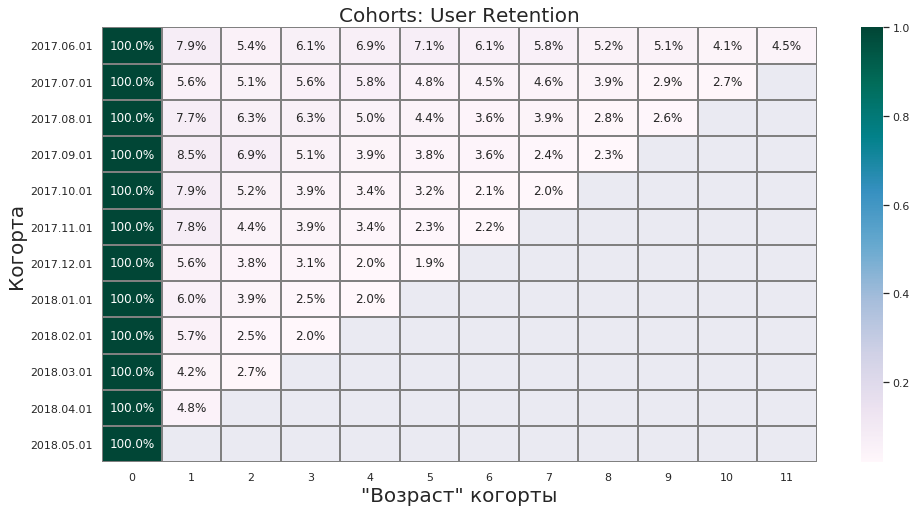

In [182]:
retention_pivot = cohorts.pivot_table(
    index='first_visit_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum'
)

sns.set(style='darkgrid')
plt.figure(figsize=(16, 8))
plt.title('Cohorts: User Retention', fontsize=20)
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='PuBuGn',
           yticklabels=retention_pivot.index.strftime('%Y.%m.%d'))
plt.xlabel('"Возраст" когорты', fontsize=20)
plt.ylabel('Когорта', fontsize=20)
plt.show()

Retention Rate показывает, сколько пользователей из когорты, относительно их изначального числа вернулось в последующие периоды. Как видим, возвращаются люди не часто.

Найдём средний Retention Rate на **второй месяц** «жизни» когорт.

In [183]:
print('{:.1%}'.format(retention_pivot[2].mean()))

4.6%


Вывода два и оба имеют место быть: 

- наиболее очевидный - концерты, театры и прочие массовые мероприятия, не самые часто посещаемые места, в пересчёте на одного человека
- наиболее неприятный - пользователям что-то не нравится на сайте и они не спешат возвращаться

### 2.2. Метрики электронной коммерции

**2.2.1. Узнаем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.**

Мы уже создавали переменную с датой первого посещения сайта. 

In [184]:
user_birth_date.to_frame().head()

,first_visit_date
uid,
11863502262781,2018-03-01 17:27:00
49537067089222,2018-02-06 15:55:00
297729379853735,2017-06-07 18:47:00
313578113262317,2017-09-18 22:49:00
325320750514679,2017-09-30 14:29:00


Теперь получим данные о дате первого заказа.

In [185]:
first_order_date = orders.groupby(['uid']).order_ts.min()
first_order_date.name = 'first_order_date'
first_order_date.to_frame().head()

,first_order_date
uid,
313578113262317,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00
2464366381792757,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00


Объединим первое посещение и первый заказ в одну таблицу. Посчитаем разницу между ними в минутах.

In [186]:
visit_to_order = pd.merge(first_order_date, user_birth_date, on='uid', how='left')
visit_to_order['visit_order_diff'] = (visit_to_order['first_order_date'] - visit_to_order['first_visit_date'])
visit_to_order['visit_order_diff'] = visit_to_order['visit_order_diff'] / np.timedelta64(1, 'm')
visit_to_order['visit_order_diff'] = visit_to_order['visit_order_diff'].round().astype('int')
visit_to_order.head()

,first_order_date,first_visit_date,visit_order_diff
uid,,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0


Узнаем среднее количество минут, от первого появления до первого заказа.

In [187]:
round(visit_to_order.visit_order_diff.mean())

24340

Почти 17 суток. Посмотрим на распределение.

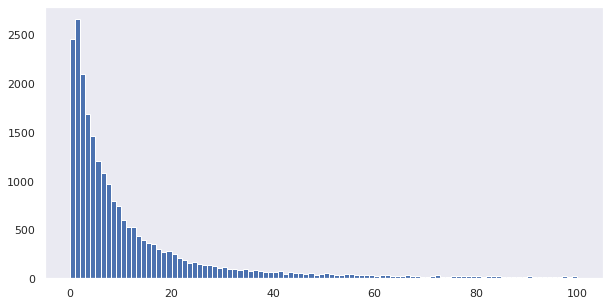

In [188]:
visit_to_order.visit_order_diff.hist(figsize=(10, 5), bins=100, range=(0, 100), grid=False)
sns.set(style='white')
plt.show()

Распределение далеко от нормального. Узнаем моду - наиболее часто встречающееся значение.

In [189]:
visit_to_order.visit_order_diff.mode()

0    1
dtype: int64

Одна минута. Достаточно, чтобы купить билет и уйти. 

**2.2.2. Рассчитаем среднее количество покупок на одного пользователя за 6 месяцев.**

Сделаем срез за полгода, сгруппируем пользователей, посчитаем количество заказов на каждого и узнаем среднее.

In [190]:
orders_half_year = orders.query('"2017-12-01" < order_ts < "2018-05-31"')
orders_half_year.groupby('uid').agg({'order_ts':'count'}).mean()

order_ts    1.339478
dtype: float64

Одно - два посещения театра, музея, или концерта за шесть месяцев. Культурного и эмоционального заряда хватает. На более частое посещение нет необходимости.

Добавим месяц заказа в основную таблицу.

In [191]:
orders['order_month'] = orders.order_ts.astype('datetime64[M]')

Присоединим ранее созданную таблицу с "визитами-в-заказы" и найдём "возраст" когорт.

In [192]:
orders_sixmonth = pd.merge(orders, visit_to_order, on='uid', how='left')

orders_sixmonth['first_order_month'] = orders_sixmonth['first_order_date'].astype('datetime64[M]')
orders_sixmonth['lifetime'] = (orders_sixmonth['order_month'] - orders_sixmonth['first_order_month']) / np.timedelta64(1, 'M')
orders_sixmonth['lifetime'] = orders_sixmonth['lifetime'].round().astype('int')
orders_sixmonth.head()

,order_ts,revenue,uid,order_month,first_order_date,first_visit_date,visit_order_diff,first_order_month,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01 00:09:00,1,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:14:00,11,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01 00:25:00,2,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01 00:14:00,15,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01 07:31:00,27,2017-06-01,0


Сгруппируем по месяцу первого заказа и месяцу жизни когорты. Посчитаем количество заказов и количество уникальных пользователей.

In [193]:
n_user_orders = orders_sixmonth.groupby(
    ['first_order_month', 'lifetime']
).agg({'uid':['count', 'nunique']}).reset_index()
n_user_orders.columns = ['first_order_month', 'lifetime', 'n_orders', 'n_users']

Узнаем количество заказов на пальзователя.

In [194]:
n_user_orders['orders_per_user'] = (
    n_user_orders['n_orders'] / n_user_orders['n_users']
)

По сводной таблице построим хитмап общего числа заказов на пользователя, по месяцам.

In [195]:
mean_orders_per_user = n_user_orders.pivot_table(
    index='first_order_month', 
    columns='lifetime', 
    values='orders_per_user')

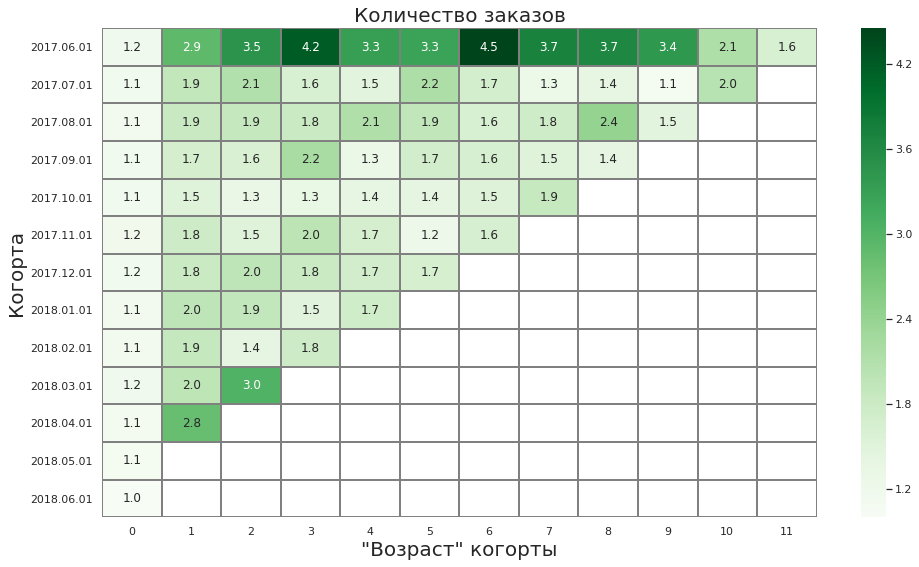

In [196]:
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Количество заказов', fontsize=20)
sns.heatmap(mean_orders_per_user, annot=True, fmt='.1f', linewidths=1, linecolor='gray',
           cmap='Greens', yticklabels=mean_orders_per_user.index.strftime('%Y.%m.%d'))
plt.xlabel('"Возраст" когорты', fontsize=20)
plt.ylabel('Когорта', fontsize=20)
plt.show()

Среднее количество заказов на пользователя, за полгода.

In [197]:
round(mean_orders_per_user[5].mean())

2

В июньской когорте, видны "всплески" заказов, совпадающие с общей пользовательскрй активностью в сентябре и ноябре. Похоже, июньская когорта "подверглась" маркетинговой кампании сильнее всего :) Или в ней больше всего культурных людей, с активной жизненной позицией.

**2.2.3. Посчитаем AOV (Average Order Value), или средний чек.**

Создадим столбец с месяцем заказа и посчитаем помесячную выручку с каждого пользователя. Чтобы узнать AOV, разделим выручку, на количество пользоваетелей.

In [198]:
#orders['order_month'] = orders.order_ts.astype('datetime64[M]')
average_order_value = orders.groupby('order_month').agg({'revenue':'sum', 'uid':'nunique'})
average_order_value['aov'] = average_order_value['revenue'] / average_order_value['uid']
round(average_order_value['aov'].mean(), 2)

5.87

Около 6 у.е.

Построим график по месяцам.

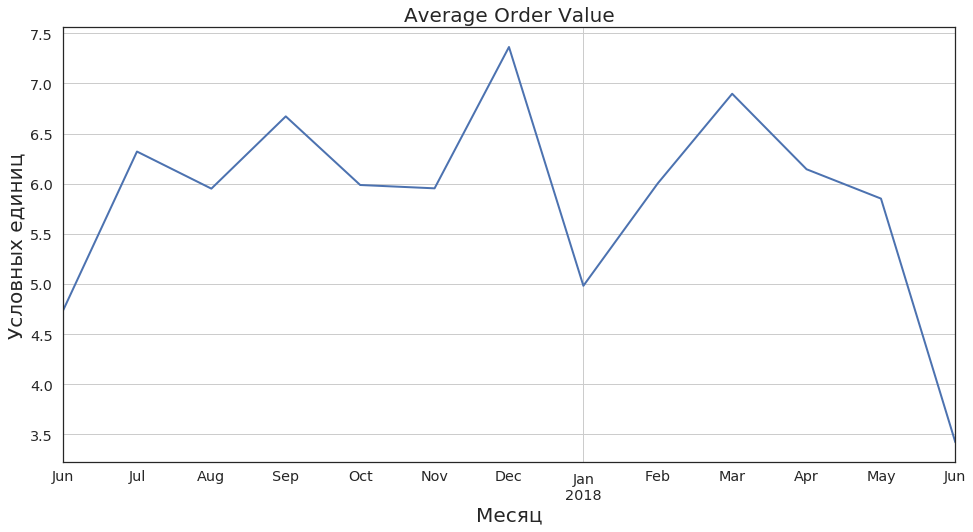

In [199]:
average_order_value[['aov']].\
plot(lw=2, grid=True, figsize=(16, 8), fontsize='large', legend=None)
plt.title('Average Order Value', fontsize=20)
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Условных единиц', fontsize=20)
plt.show()

После пикового повышения в конце ноября, средний чек резко упал к новому году. Билеты покупаются заранее, а декабрь - месяц предновогодних массовых мероприятий, концертов и прочих торжеств. На праздничной волне, люди стараются посетить как можно больше мест, в том числе и с детьми. Детей одних не отпустишь - отсюда вытекает покупка, как минимум, двух билетов. Больше билетов - больше средний чек. 


Падение в мае, можно списать на хорошую погоду и желание людей проводить больше времени на природе, а не в музее. К сожалению, подобное желание может затронуть и маркетологов, что приведёт к слабой, не проработанной маркетинговой стратегии.

**2.2.4. Рассчитаем LTV (Lifetime Value) - сумму денег, которую, в среднем, приносит компании один клиент, со всех своих покупок.** 

LTV удобно считать по когортам. Вспомним таблицу с заказами.

In [200]:
orders.head()

,order_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


Получим месяц первой покупки каждого клиента и посчитаем количество новых покупателей (new_buyers) за каждый месяц

In [201]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'new_buyers']
cohort_sizes

,first_order_month,new_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Добавим месяц первой покупки каждого покупателя в таблицу с заказами:

In [202]:
orders_first_month = pd.merge(orders, first_orders, on='uid')
orders_first_month.head()

,order_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.

In [203]:
cohorts = orders_first_month.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество пользователей. Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [204]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

LTV считается не из выручки, а из валовой прибыли (gross profit). Значит, нужно найти валовую прибыль, умножив выручку на маржинальность. По данным Яндекс.Афиши - маржинальность сервиса равна 100%.


Также, LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты. 


Для подсчёта LTV, нужно разделить валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.

In [205]:
margin_rate = 1

report['gp'] =  report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['new_buyers']
report.head()

,first_order_month,new_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


Посмотрим, как меняется LTV по когортам.

In [206]:
report.groupby('first_order_month').ltv.sum().round(2).to_frame()

,ltv
first_order_month,
2017-06-01,11.88
2017-07-01,8.39
2017-08-01,8.47
2017-09-01,13.44
2017-10-01,6.36
2017-11-01,6.40
2017-12-01,7.64
2018-01-01,4.94
2018-02-01,4.59


Исходя из значений LTV, самыми лояльными, приносящими наибольшую прибыль, являются когорты с июня по сентябрь 2017 года.

Построим тепловую карту.

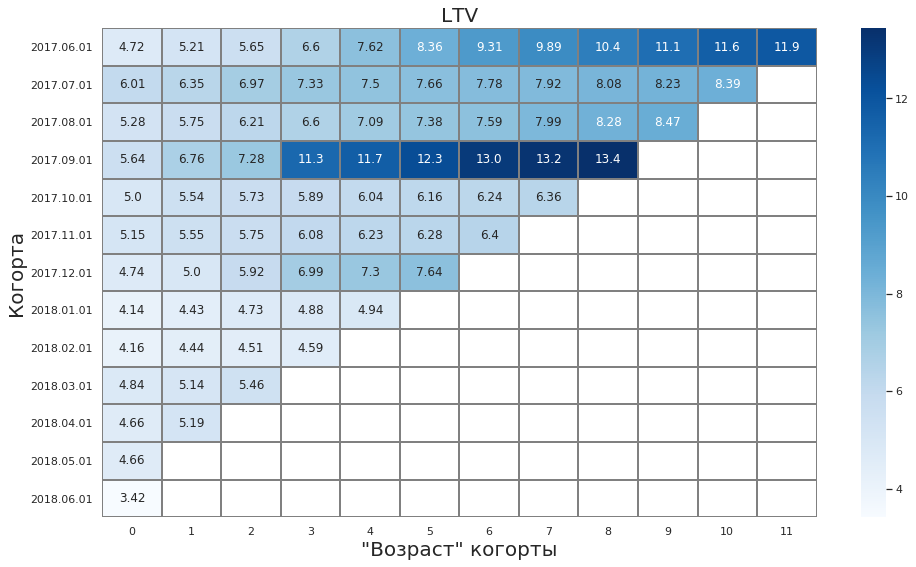

In [207]:
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output = output.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('LTV', fontsize=20)
sns.heatmap(output, annot=True, fmt='.3', linewidths=1, linecolor='gray',
           cmap='Blues', yticklabels=output.index.strftime('%Y.%m.%d'))
plt.xlabel('"Возраст" когорты', fontsize=20)
plt.ylabel('Когорта', fontsize=20)
plt.show()

На графике видно, что самая "активная" когорта - сентябрьская. За девять месяце "жизни", она, в среднем, принесла больше прибыли, чем июньская за год.

**Рассчитаем средний LTV по когортам за полгода. В расчёт возьмём "возрастные" когорты, "прожившие" не менее 6 месяцев.**

Сделаем полугодовой срез и ограничим "возраст" когорт шестью месяцами.

In [208]:
report_six_month = report.loc[report['first_order_month'] <= '2017-11-01']
report_six_month = report_six_month.loc[report_six_month['age'] <= 6]

Сделаем сводню таблицу и выведем по ней тепловую карту.

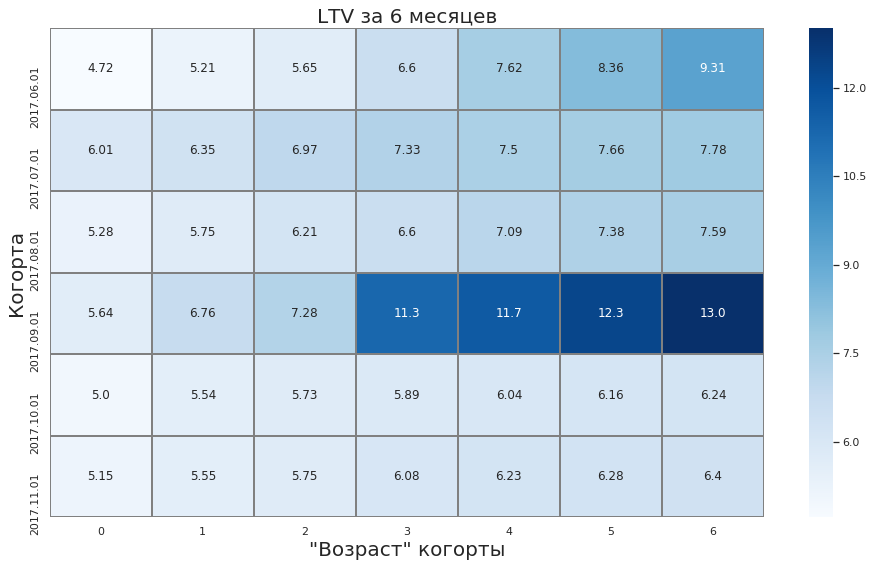

In [209]:
output_six_month = report_six_month.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output_six_month = output_six_month.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('LTV за 6 месяцев', fontsize=20)
sns.heatmap(output_six_month, annot=True, fmt='.3', linewidths=1, linecolor='gray',
           cmap='Blues', yticklabels=output_six_month.index.strftime('%Y.%m.%d'))
plt.xlabel('"Возраст" когорты', fontsize=20)
plt.ylabel('Когорта', fontsize=20)
plt.show()

Рассчитаем LTV за 6 месяцев для средней когорты.

In [210]:
round(output_six_month[6].mean())

8

Средний LTV за полгода после первой покупки, равен 8 у.е.

### 2.3. Маркетинговые метрики

**2.3.1. Посчитаем общую сумму расходов на маркетинг.**

Вспомним таблицу с расходами.

In [211]:
costs.head()

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Узнаем, сколько всего было затрачено на маркетинг.

In [212]:
costs.costs.sum()

329131.62

Построим график трат.

In [213]:
costs['month'] = costs['date'].astype('datetime64[M]')

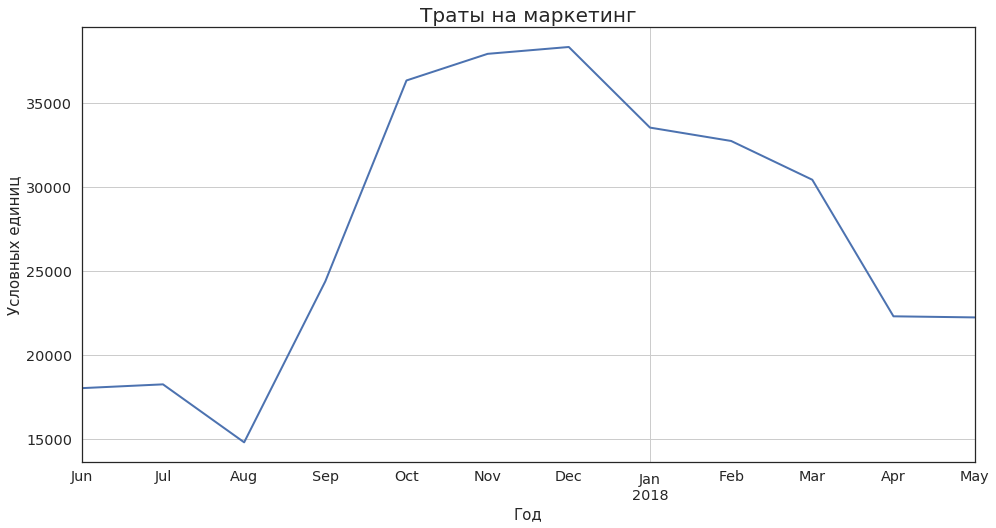

In [214]:
costs.groupby('month').costs.sum().\
plot(lw=2, grid=True, figsize=(16, 8), fontsize='large', legend=None)
plt.xlim('2017-06-01', '2018-05-31')
plt.title('Траты на маркетинг', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Условных единиц', fontsize=15)
plt.show()

Траты на маркетинг резко повышаются к сентябрю и растут до декабря. После - идёт медленный спад.

**Выясним распределение трат по источникам**

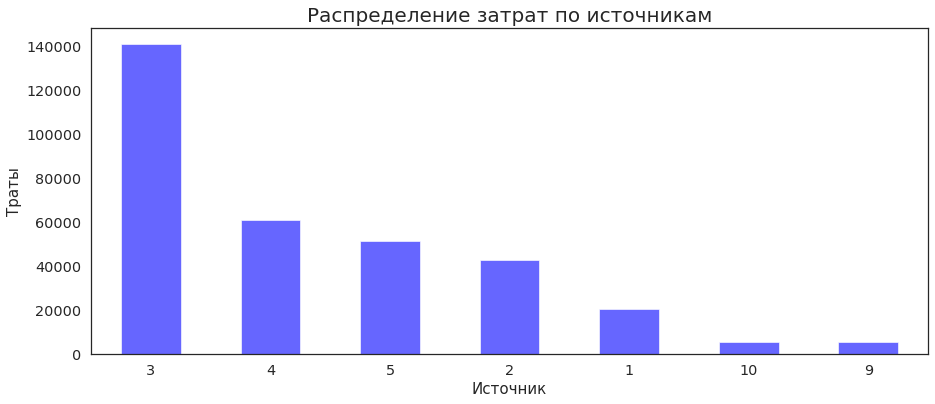

In [215]:
costs.groupby('source_id').costs.sum().sort_values(ascending=False).\
plot.bar(figsize=(15, 6), color='blue', alpha=0.6, fontsize='large', legend=None, rot=0)
plt.title('Распределение затрат по источникам', fontsize=20)
plt.xlabel('Источник', fontsize=15)
plt.ylabel('Траты', fontsize=15)
plt.show()

Самый затратный - источник номер 3.

Добавим столбец с месяцем и построим график распределения трат.

In [216]:
#costs['month'] = costs['date'].astype('datetime64[M]')

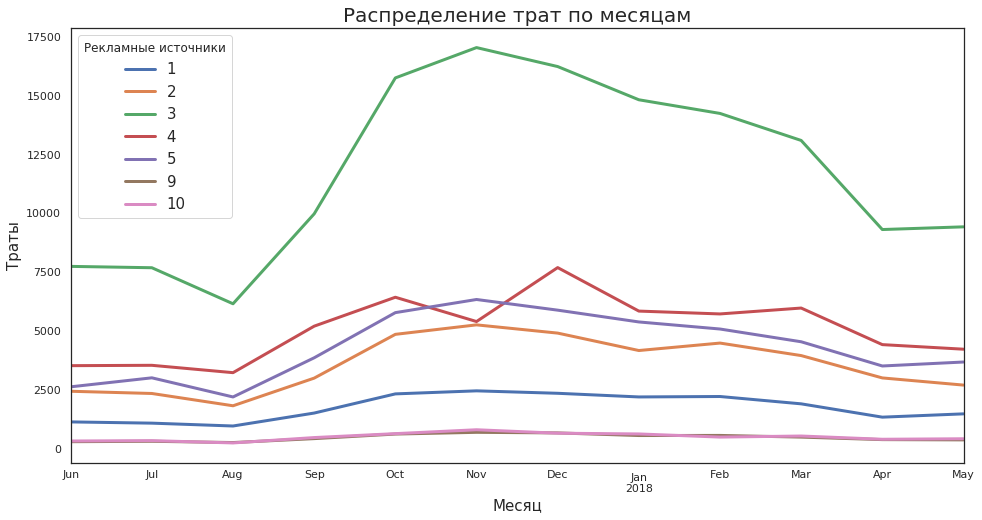

In [217]:
costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum').\
plot(lw=3, figsize=(16, 8), grid=False)
plt.title('Распределение трат по месяцам', fontsize=20)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Траты', fontsize=15)
plt.legend(title='Рекламные источники', fontsize=15)
plt.show()

С августа по ноябрь 2017, наблюдается подъём общих расходов на маркетинг. Затем, с декабря - медленный спад.

**2.3.2. Рассчитаем CAC (Customer Aquisition Cost) - среднюю стоимость привлечения клиента.**

Найдём сумму расходов на маркетинг за каждый месяц

In [218]:
monthly_costs = costs.groupby('month').costs.sum().to_frame()
monthly_costs

,costs
month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


Рассчитаем общее количество совершивших покупку пользователей, по месяцам.

In [219]:
number_customers_month = orders.groupby('order_month').agg({'uid':'nunique'}).reset_index()
number_customers_month.columns = ['month', 'n_user']

Узнаем затраты на маркетинг по месяцам и источникам.

In [220]:
costs_by_source = costs.groupby('month').agg({'costs':'sum'}).reset_index()
costs_by_source.columns = ['month', 'sum_costs']

Объединим две таблицы и посчитаем CAC.

In [221]:
cac_by_month = pd.merge(costs_by_source, number_customers_month, on='month')
cac_by_month['cac'] = round((cac_by_month['sum_costs'] / cac_by_month['n_user']), 2)
cac_by_month

,month,sum_costs,n_user,cac
0,2017-06-01,18015.00,2023,8.91
1,2017-07-01,18240.59,1984,9.19
2,2017-08-01,14790.54,1472,10.05
3,2017-09-01,24368.91,2750,8.86
4,2017-10-01,36322.88,4675,7.77
5,2017-11-01,37907.88,4547,8.34
6,2017-12-01,38315.35,4942,7.75
7,2018-01-01,33518.52,3898,8.60
8,2018-02-01,32723.03,4258,7.69
9,2018-03-01,30415.27,4181,7.27


Найдём среднее значение CAC по всему периоду.

In [222]:
round(cac_by_month.cac.mean(), 2)

8.24

Построим график среднего CAC по месяцам.

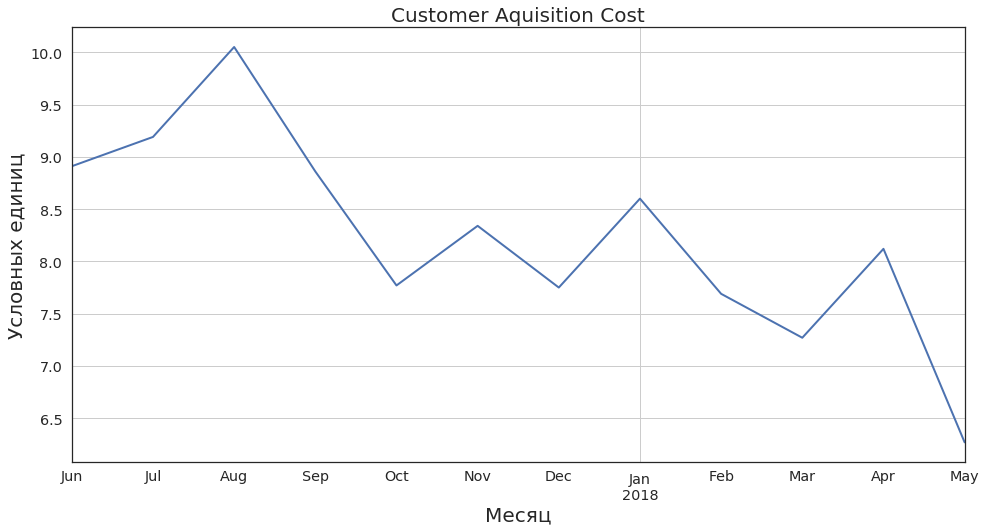

In [223]:
cac_by_month.groupby('month').agg({'cac':'mean'}).\
plot(lw=2, grid=True, figsize=(16, 8), fontsize='large', legend=None)
plt.title('Customer Aquisition Cost', fontsize=20)
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Условных единиц', fontsize=20)
plt.show()

В августе, стоимость привлечения одного клиента выросла. Возможно, именно этим обусловлен высокий LTV сентябрьской когорты. Компания вложилась в маркетинг - отсюда и результат.


Однако, в последующие месяцы, видна общая тенденция спада трат на привлечение покупателя.

Вспомним средний чек.

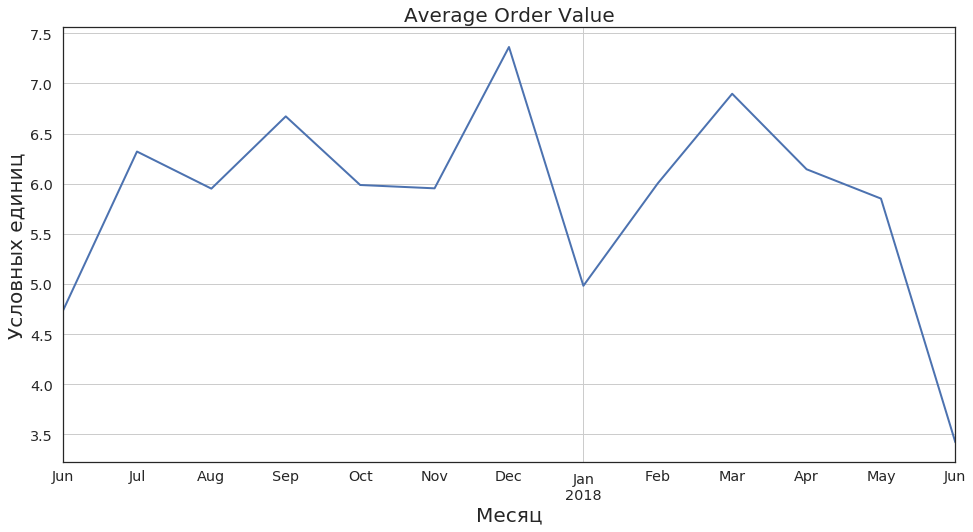

In [224]:
average_order_value[['aov']].\
plot(lw=2, grid=True, figsize=(16, 8), fontsize='large', legend=None)
plt.title('Average Order Value', fontsize=20)
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Условных единиц', fontsize=20)
plt.show()

Затраты на привлечение одного клиента - ниже среднего чека. Возможно, маркетинговые кампании не очень эффективны.

**Рассчитаем среднюю стоимость привлечения клиента для каждого источника трафика**

Выясним источник и месяц певого визита.

In [230]:
first_source = visits.sort_values(by = ['uid', 'session_start_ts']).\
groupby('uid').agg({'source_id': 'first', 'visit_month': 'first'}).reset_index()

first_source.rename(columns={'visit_month':'month'}, inplace=True)
first_source.head()

,uid,source_id,month
0,11863502262781,3,2018-03-01
1,49537067089222,2,2018-02-01
2,297729379853735,3,2017-06-01
3,313578113262317,2,2017-09-01
4,325320750514679,5,2017-09-01


Вспомним таблицу с месяцем первого заказа.

In [231]:
first_orders.head(3)

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01


Объединим две таблицы.

In [232]:
orders_first_source = pd.merge(first_orders, first_source, on='uid', how='left')
orders_first_source.head()

,uid,first_order_month,source_id,month
0,313578113262317,2018-01-01,2,2017-09-01
1,1575281904278712,2017-06-01,10,2017-06-01
2,2429014661409475,2017-10-01,3,2017-10-01
3,2464366381792757,2018-01-01,5,2018-01-01
4,2551852515556206,2017-11-01,5,2017-11-01


Найдём количество пользователей в месяц, пришедших из каждого источника и сделавших заказ.

In [233]:
orders_first_source_grouped = orders_first_source.groupby(['first_order_month', 'source_id']).agg({'uid':'count'}).reset_index()
orders_first_source_grouped.head()

,first_order_month,source_id,uid
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


Посчитаем общие расходы в месяц по источникам.

In [234]:
costs_source_grouped = costs.groupby(['month', 'source_id']).costs.sum().reset_index()
costs_source_grouped.head()

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


Объединим таблицы с расходами и пользователями и посчитаем CAC.

In [235]:
cac_by_source = pd.merge(orders_first_source_grouped, costs_source_grouped, left_on=['first_order_month', 'source_id'], 
                        right_on=['month', 'source_id'])
cac_by_source['cac'] = round((cac_by_source['costs'] / cac_by_source['uid']), 2)
cac_by_source.head()

,first_order_month,source_id,uid,month,costs,cac
0,2017-06-01,1,190,2017-06-01,1125.61,5.92
1,2017-06-01,2,235,2017-06-01,2427.38,10.33
2,2017-06-01,3,638,2017-06-01,7731.65,12.12
3,2017-06-01,4,413,2017-06-01,3514.80,8.51
4,2017-06-01,5,384,2017-06-01,2616.12,6.81


Построим график по сводной таблице.

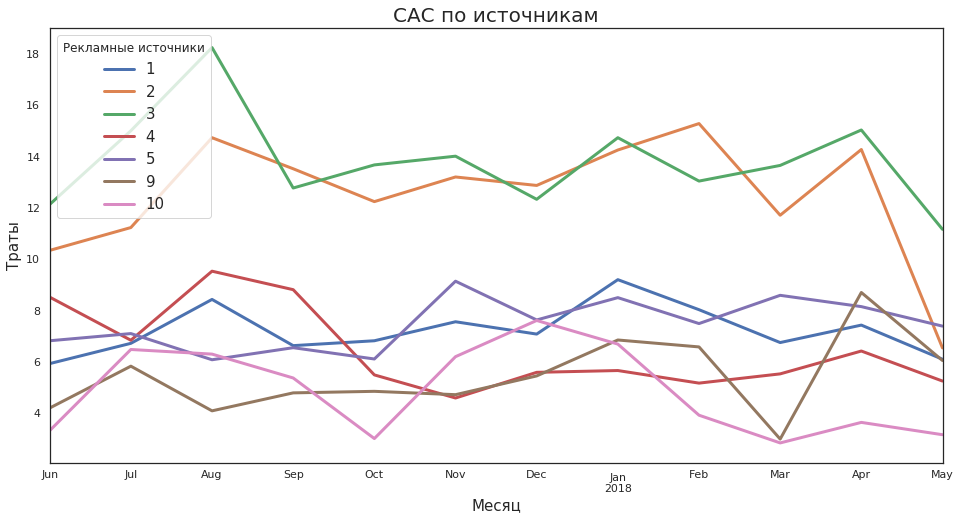

In [236]:
cac_by_source.pivot_table(
    index='first_order_month', 
    columns='source_id', 
    values='cac',
    aggfunc='mean'
).plot(lw=3, figsize=(16, 8), grid=False)
plt.title('CAC по источникам', fontsize=20)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Траты', fontsize=15)
plt.legend(title='Рекламные источники', fontsize=15)
plt.show()

Как видно из графика, в среднем, наибольшая стоимость привлечения клиента, приходится на 2-й и 3-й источник.

**2.3.3. Рассчитаем возврат инвестиций в маркетинг - ROMI (Return on Marketing Investment) - по когортам, в разрезе источников.**

Таблица с первым источником посещения.

In [237]:
first_source.head(3)

,uid,source_id,month
0,11863502262781,3,2018-03-01
1,49537067089222,2,2018-02-01
2,297729379853735,3,2017-06-01


Таблица с первым месяцем заказа.

In [238]:
orders_first_month.head(3)

,order_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01


Объединим две таблицы.

In [239]:
source_orders = orders_first_month.merge(first_source, on = 'uid')
source_orders.head()

,order_ts,revenue,uid,order_month,first_order_month,source_id,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3,2017-06-01


Посчитаем количество уникальных пользователей, пришедших из определённого источника первый раз и сделавших заказ.

In [240]:
unique_uid = (source_orders.groupby(['source_id', 'first_order_month', 'order_ts'])
                .agg({'uid':'nunique'})).reset_index()
unique_uid.head(3)

,source_id,first_order_month,order_ts,uid
0,1,2017-06-01,2017-06-01 00:10:00,1
1,1,2017-06-01,2017-06-01 09:22:00,1
2,1,2017-06-01,2017-06-01 09:23:00,1


Посчитаем выручку с каждого заказа.

In [241]:
revenue = (source_orders.groupby(['source_id', 'first_order_month', 'order_ts'])
                .agg({'revenue':'sum'})).reset_index()
revenue.head(3)

,source_id,first_order_month,order_ts,revenue
0,1,2017-06-01,2017-06-01 00:10:00,17.00
1,1,2017-06-01,2017-06-01 09:22:00,1.22
2,1,2017-06-01,2017-06-01 09:23:00,0.37


Объединим две полученные таблицы с рассчётами.

In [242]:
united = unique_uid.merge(revenue, on=['source_id', 'first_order_month', 'order_ts'])
united.head(3)

,source_id,first_order_month,order_ts,uid,revenue
0,1,2017-06-01,2017-06-01 00:10:00,1,17.00
1,1,2017-06-01,2017-06-01 09:22:00,1,1.22
2,1,2017-06-01,2017-06-01 09:23:00,1,0.37


Узнаем "возраст" когорт и посчитаем LTV. 

In [243]:
united['age'] = ((united['order_ts'] - united['first_order_month'])/ np.timedelta64(1, 'M'))
united['age'] = united['age'].round().astype('int')

united['ltv'] = united['revenue']/united['uid']
united.head(3)

,source_id,first_order_month,order_ts,uid,revenue,age,ltv
0,1,2017-06-01,2017-06-01 00:10:00,1,17.00,0,17.00
1,1,2017-06-01,2017-06-01 09:22:00,1,1.22,0,1.22
2,1,2017-06-01,2017-06-01 09:23:00,1,0.37,0,0.37


Присоединим когортную таблицу к таблице с затратами на маркетинг.

In [244]:
costs_romi = costs.merge(united, left_on=['source_id', 'month'], right_on=['source_id', 'first_order_month'])
costs_romi.head(3)

,source_id,date,costs,month,first_order_month,order_ts,uid,revenue,age,ltv
0,1,2017-06-01,75.2,2017-06-01,2017-06-01,2017-06-01 00:10:00,1,17.00,0,17.00
1,1,2017-06-01,75.2,2017-06-01,2017-06-01,2017-06-01 09:22:00,1,1.22,0,1.22
2,1,2017-06-01,75.2,2017-06-01,2017-06-01,2017-06-01 09:23:00,1,0.37,0,0.37


Посчитаем CAC и ROMI. Создадим тепловую карту ROMI по источникам. 

In [245]:
costs_romi['cac'] = costs_romi['costs'] / costs_romi['uid']
costs_romi['romi'] = costs_romi['ltv'] / costs_romi['cac']
costs_romi.head()

,source_id,date,costs,month,first_order_month,order_ts,uid,revenue,age,ltv,cac,romi
0,1,2017-06-01,75.2,2017-06-01,2017-06-01,2017-06-01 00:10:00,1,17.00,0,17.00,75.2,0.226064
1,1,2017-06-01,75.2,2017-06-01,2017-06-01,2017-06-01 09:22:00,1,1.22,0,1.22,75.2,0.016223
2,1,2017-06-01,75.2,2017-06-01,2017-06-01,2017-06-01 09:23:00,1,0.37,0,0.37,75.2,0.004920
3,1,2017-06-01,75.2,2017-06-01,2017-06-01,2017-06-01 10:38:00,1,2.08,0,2.08,75.2,0.027660
4,1,2017-06-01,75.2,2017-06-01,2017-06-01,2017-06-01 11:01:00,1,1.67,0,1.67,75.2,0.022207


In [246]:
costs_romi['first_order_month'] = costs_romi['first_order_month'].dt.strftime('%Y-%m')

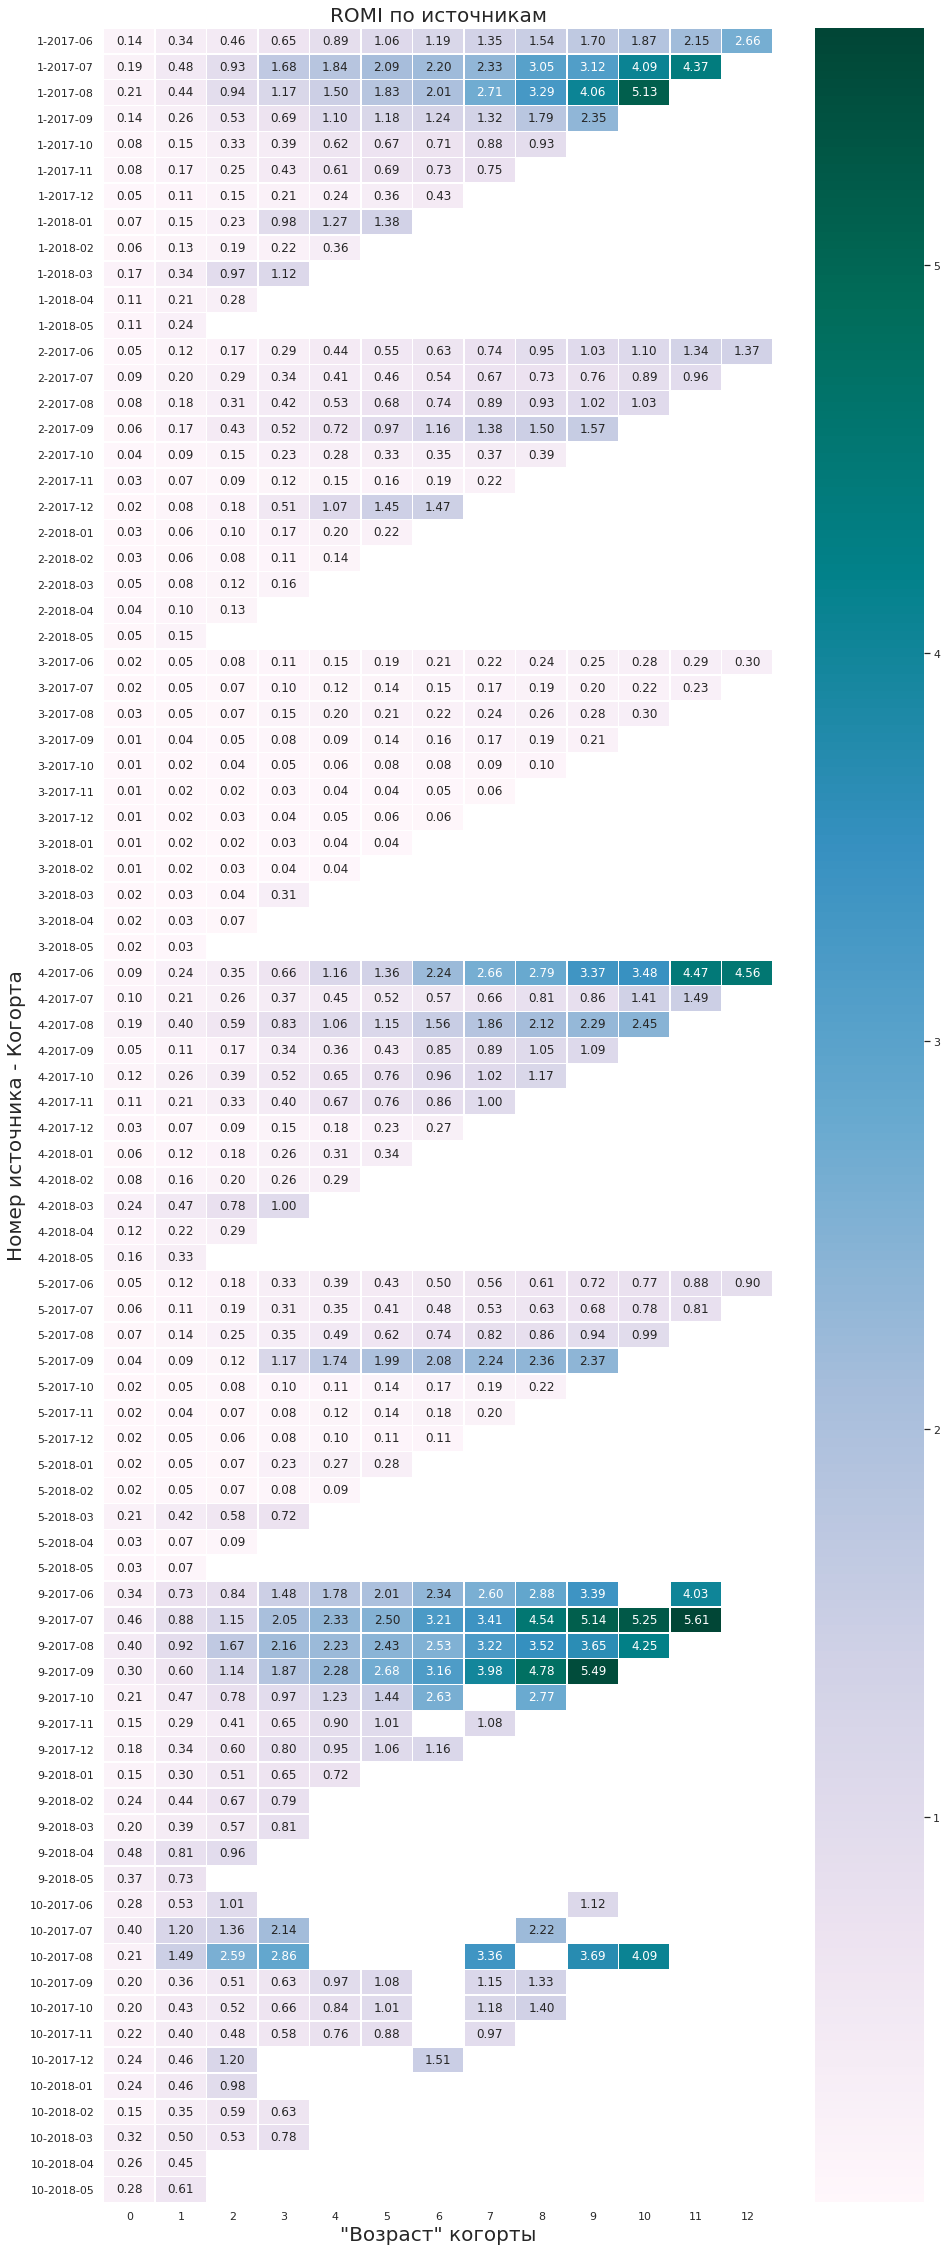

In [247]:
romi_output = costs_romi.pivot_table(
    index=['source_id', 'first_order_month'], columns='age', values='romi', aggfunc='mean'
).cumsum(axis=1)

sns.set(style='white')
plt.figure(figsize=(15, 40))
sns.heatmap(romi_output, annot=True, fmt=".2f", linewidths=.5, cmap = 'PuBuGn')
plt.title('ROMI по источникам', fontsize=20)
plt.ylabel('Номер источника - Когорта', fontsize=20)
plt.xlabel('"Возраст" когорты', fontsize=20)
plt.show()

Как видно из общей тепловой карты, наибольший возврат маркетинговых инвестиций приходится на источник 1, 4 и 9. Следует обратить на них пристальное внимание.

### Выводы и рекоммендации:

**Анализ продуктовых метрик показал:**

- Рост количества уникальных пользователей, приходится на период с сентября по конец ноября 2017 года. С декабря 2017 года до мая 2018 года их количество падает.
- Рост и падение, как показал анализ маркетинговых метрик, напрямую зависел проведения маркетинговых компаний.
- В среднем, пользователь заходит на сайт не более одного раза в день.
- Типичная пользовательская сессия равна шестидесяти секундам, или одной минуте. Возможно, стоит развернуть кампанию на удержание пользователя.
- Короткие сессии и низкий Retention Rate показывают, что пользователи не задерживаются на сайте. Скорее всего, маркентиговые кампании больше ориентируются на привлечение новых клиентов, а не на удержание старых.

**Анализ метрик электронной комерции показал:**

- С момента первого посещения сайта до совершения покупки, в среднем, проходит одна минута. Как правило, люди приходят на сайт уже зная, на какое мероприятие купить билет.
- В среднем, пользователь за 6 месяцев делает 2 заказа.
- С марта 2018 года, наблюдается снижение среднего чека.
- Самыми лояльными, приносящими наибольшую прибыль, являются когорты с июня по сентябрь 2017 года.

**Рассчеты маркетинговых метрик показывают, что:**

- Общая сумма расходов на маркетинг, снижается с декабря 2017 года.
- Самый затратный источник трафика - источник номер 3.
- В августе, стоимость привлечения одного клиента выросла. Возможно, именно этим обусловлен высокий LTV сентябрьской когорты. Компания вложилась в маркетинг - отсюда и результат.
- В последующие за сентябрём месяцы, видна общая тенденция спада трат на привлечение покупателя.
- Customer Aquisition Cost оказался выше среднего чека, что говорит о, возможно, низкой эффективности рекламных кампаний.
- Наибольшая стоимость привлечения клиента приходится на 2 и 3 источники.
- Наибольший ROMI - возврат маркетинговых инвестиций - приходится на 1, 4 и 9 источники.
- Считая от нулевого месяца, в основном, маркетинговые инвестиции начинают окупаться на второй месяц жизни когорт.
- Сравнивая одинаковые периоды жизни, например 4 месяца, наибольший возврат маркетинговых инвестиций приносят когорты с июня по сентябрь 2017 года.
- Маркентинговую кампанию необходимо направить на удержание клиентов когорт с июня по сентябрь 2017 года.

**Наибольший возврат маркетинговых инвестиций (ROMI), приходится на 1, 4 и 9 источники трафика. При этом, самые высокие затраты на привлечение клиента (САС), уходят на источник 2 и 3. Следовательно, предлагается перераспределить бюджет, в пользу наиболее выгодных из представленных источников!**
